# Projet 6 : Classification des biens de consommation
## Partie 3 : Classification à partir d'images

In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, silhouette_score
from sklearn import cluster ,manifold, decomposition ,preprocessing ,metrics
from sklearn.cluster import KMeans, MiniBatchKMeans

In [4]:
from PIL import Image, ImageOps ,ImageFilter
from matplotlib.image import imread
import cv2 as cv

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from glob import glob
os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-05-22 00:43:19.346680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 00:43:20.260278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-05-22 00:43:21.420107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 00:43:21.797510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 00:43:21.798325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
pd.set_option("display.max_colwidth", 100)

# Etape 2 : classification supervisée
2 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images


## Création du modèle de classification

In [13]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [14]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['images_processed'])) :
        img = (load_img(data['images_processed'][image_num],target_size=(224, 224)))
        #image = tf.cast(img, tf.float32)
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

### Chargement de données néttoyées préalablement

In [15]:
data_train=pd.read_csv("./data/data_1/dataset_train/data_train.csv")
data_test=pd.read_csv("./data/data_1/dataset_test/data_test.csv")

In [91]:
data_train.columns

Index(['image', 'image_path', 'cat_lvl_1', 'label', 'Largeur_img',
       'Hauteur_img', 'Taille_img', 'Format_img', 'images_processed',
       'images_processed_gray'],
      dtype='object')

In [16]:
data_train = data_train.reset_index()  
images_np = image_prep_fct(data_train)
print(images_np.shape)

data_test = data_test.reset_index() 
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(787, 224, 224, 3)
(263, 224, 224, 3)


In [17]:
X = images_np
#y = data_train['label']
y = to_categorical(data_train['label'])

X_test = images_np_test
#y_test = data_test['label']
y_test = to_categorical(data_test['label'])

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((629, 224, 224, 3), (629, 7), (158, 224, 224, 3), (158, 7))

In [19]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

2023-05-22 00:48:34.981126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 00:48:34.981477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 00:48:34.981717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

2023-05-22 00:48:43.229603: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 378728448 exceeds 10% of free system memory.
2023-05-22 00:48:43.536892: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 378728448 exceeds 10% of free system memory.


Epoch 1/50


2023-05-22 00:48:45.866104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2023-05-22 00:48:50.772754: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-22 00:48:50.772797: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-22 00:48:56.106203: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1f89dc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-22 00:48:56.106228: I tensorflow/compiler/xla/service/service.cc:177]   StreamE

20/20 [==============================] - ETA: 0s - loss: 4.9831 - accuracy: 0.4499
Epoch 1: val_loss improved from inf to 1.82745, saving model to ./model1_best_weights.h5
20/20 [==============================] - 28s 787ms/step - loss: 4.9831 - accuracy: 0.4499 - val_loss: 1.8274 - val_accuracy: 0.7342
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.8904 - accuracy: 0.6709
Epoch 2: val_loss improved from 1.82745 to 1.41744, saving model to ./model1_best_weights.h5
20/20 [==============================] - 10s 541ms/step - loss: 1.8904 - accuracy: 0.6709 - val_loss: 1.4174 - val_accuracy: 0.7468
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.2552 - accuracy: 0.7202
Epoch 3: val_loss did not improve from 1.41744
20/20 [==============================] - 5s 246ms/step - loss: 1.2552 - accuracy: 0.7202 - val_loss: 1.7125 - val_accuracy: 0.7278
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.8977 - accuracy: 0.7901
Epoch 4: va

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Score du dernier epoch

In [ ]:
with tf.device('/gpu:0'):
    loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
    print("Training Accuracy: {:.4f}".format(accuracy))

In [20]:
with tf.device('/gpu:0'):
    loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
    print("Validation Accuracy:  {:.4f}".format(accuracy))

5/5 [==============================] - 1s 191ms/step - loss: 1.5528 - accuracy: 0.7785
Validation Accuracy:  0.7785


# Score de l'epoch optimal

In [21]:
model1.load_weights(model1_save_path1)

In [22]:
with tf.device('/gpu:0'):
    loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7532


In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
with tf.device('/gpu:0'):
    loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
    print("Test Accuracy       :  {:.4f}".format(accuracy))

Test Accuracy       :  0.7871


In [25]:
#pip install plot-keras-history

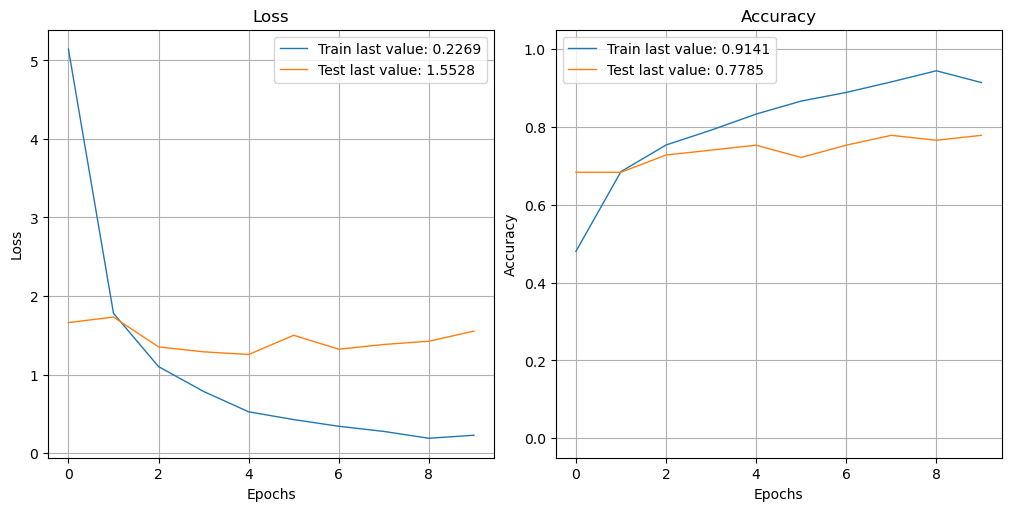

In [26]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [27]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

5/5 [==============================] - 1s 193ms/step
[6 2 0 6 4 0 6 5 4 6 3 3 4 6 5 3 4 5 2 4 5 5 3 1 2 3 4 2 5 3 1 0 5 6 6 4 0
 2 3 0 3 3 0 6 6 0 0 3 1 2 6 4 2 2 6 1 1 3 4 0 0 2 1 0 0 1 4 3 4 2 1 3 2 3
 3 1 1 1 4 4 6 1 2 0 4 2 4 0 4 5 4 1 0 6 2 2 5 5 1 1 1 4 5 0 5 1 6 0 0 2 6
 6 5 1 3 4 2 5 5 5 6 2 5 4 2 2 6 5 0 6 2 1 3 0 3 1 0 6 1 3 6 0 3 0 6 6 5 4
 5 2 4 0 6 3 5 1 3 0]

[6 2 0 6 4 3 6 2 2 6 3 3 4 6 2 2 3 5 2 1 3 5 3 1 6 3 3 2 5 3 1 0 2 6 6 0 0
 5 3 0 3 3 0 6 6 0 0 3 1 2 6 4 2 2 6 1 1 3 4 4 0 2 1 0 0 1 4 3 4 2 1 3 2 3
 4 1 1 1 3 0 6 1 3 4 0 2 4 4 4 5 4 1 2 6 3 2 3 1 0 4 1 4 5 0 5 1 6 4 0 2 6
 6 1 1 3 3 2 5 5 5 6 2 5 0 2 2 6 5 3 6 2 1 3 0 4 1 3 6 1 3 6 1 3 0 6 6 5 0
 5 0 4 0 6 6 5 1 3 5]


In [28]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[15  1  1  3  4  1  0]
 [ 1 20  0  0  1  0  0]
 [ 1  0 17  2  0  1  1]
 [ 0  0  1 18  2  0  1]
 [ 5  1  1  4 11  0  0]
 [ 0  2  3  2  0 14  0]
 [ 0  0  0  0  0  0 24]]


In [27]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [30]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[15  1  1  3  4  1  0]
 [ 1 20  0  0  1  0  0]
 [ 1  0 17  2  0  1  1]
 [ 0  0  1 18  2  0  1]
 [ 5  1  1  4 11  0  0]
 [ 0  2  3  2  0 14  0]
 [ 0  0  0  0  0  0 24]]

              precision    recall  f1-score   support

           0       0.68      0.60      0.64        25
           1       0.83      0.91      0.87        22
           2       0.74      0.77      0.76        22
           3       0.62      0.82      0.71        22
           4       0.61      0.50      0.55        22
           5       0.88      0.67      0.76        21
           6       0.92      1.00      0.96        24

    accuracy                           0.75       158
   macro avg       0.75      0.75      0.75       158
weighted avg       0.75      0.75      0.75       158



In [30]:
list_labels = data_train['cat_lvl_1'].value_counts()

In [31]:
list_labels.index

Index(['Baby Care', 'Watches', 'Computers', 'Home Furnishing',
       'Home Decor & Festive Needs', 'Beauty and Personal Care',
       'Kitchen & Dining'],
      dtype='object')

<Axes: >

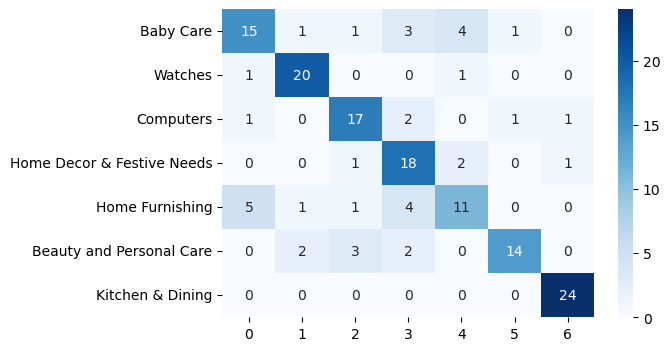

In [34]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels.index],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "" contenant de la  sont désormais bien affectées à "" et non pas ""

## Approche ImageDatagenerator avec data augmentation

In [14]:
data_train.shape

(787, 11)

In [15]:
# Pour mélanger les images, classées initalement par classe
data_train = data_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
batch_size = 64

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='images_processed', y_col='cat_lvl_1',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [37]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 591 validated image filenames belonging to 7 classes.
Found 196 validated image filenames belonging to 7 classes.
Found 263 validated image filenames belonging to 7 classes.


In [69]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [70]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [81]:
#with tf.device('/gpu:0'):
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,validation_data=val_flow,batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50


2023-05-22 00:26:49.099518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.7614

2023-05-22 00:26:57.378456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss did not improve from 0.90827
10/10 [==============================] - 11s 1s/step - loss: 0.7916 - accuracy: 0.7614 - val_loss: 1.0220 - val_accuracy: 0.7143
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7936
Epoch 2: val_loss improved from 0.90827 to 0.82741, saving model to ./model2_best_weights.h5
10/10 [==============================] - 10s 1s/step - loss: 0.6753 - accuracy: 0.7936 - val_loss: 0.8274 - val_accuracy: 0.7755
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.7648
Epoch 3: val_loss did not improve from 0.82741
10/10 [==============================] - 11s 1s/step - loss: 0.6788 - accuracy: 0.7648 - val_loss: 0.9396 - val_accuracy: 0.7245
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.5775 - accuracy: 0.8105
Epoch 4: val_loss did not improve from 0.82741
10/10 [==============================] - 10s 966ms/step - loss: 0.5775 - accuracy: 0.8105 - val_

# Score du dernier epoch

In [82]:
with tf.device('/gpu:0'):
    loss, accuracy = model2.evaluate(train_flow, verbose=True)
    print("Training Accuracy   : {:.4f}".format(accuracy))

2023-05-22 00:29:11.573422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 7s 645ms/step - loss: 0.0978 - accuracy: 0.9679
Training Accuracy   : 0.9679


In [83]:
with tf.device('/gpu:0'):
    loss, accuracy = model2.evaluate(val_flow, verbose=True)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

2023-05-22 00:29:36.785218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Accuracy :  0.7551


# Score de l'epoch optimal

In [84]:
model2.load_weights(model2_save_path)

In [85]:
with tf.device('/gpu:0'):
    loss, accuracy = model2.evaluate(val_flow, verbose=False)
    print("Validation Accuracy :  {:.4f}".format(accuracy))

2023-05-22 00:29:57.481371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Accuracy :  0.7500


In [86]:
with tf.device('/gpu:0'):
    loss, accuracy = model2.evaluate(test_flow, verbose=False)
    print("Test Accuracy       :  {:.4f}".format(accuracy))

2023-05-22 00:30:10.037394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Accuracy       :  0.7719


In [87]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

2023-05-22 00:30:17.317131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 7s 671ms/step - loss: 0.1777 - accuracy: 0.9374
Training Accuracy   : 0.9374



2023-05-22 00:30:25.324728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 3s 482ms/step - loss: 0.8913 - accuracy: 0.7449
Validation Accuracy :  0.7449


In [88]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


2023-05-22 00:30:28.661320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Accuracy :  0.7449


2023-05-22 00:30:31.544238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Accuracy       :  0.7719


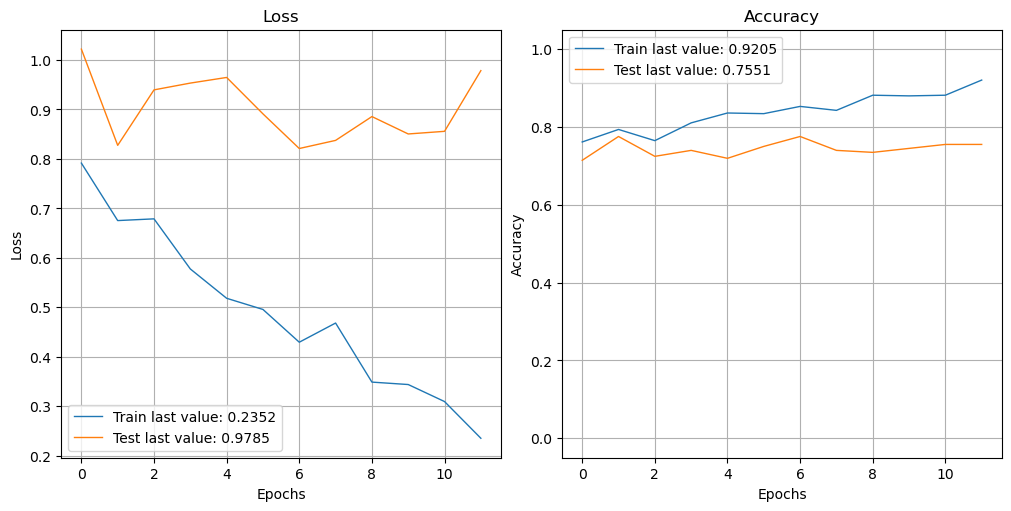

In [89]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

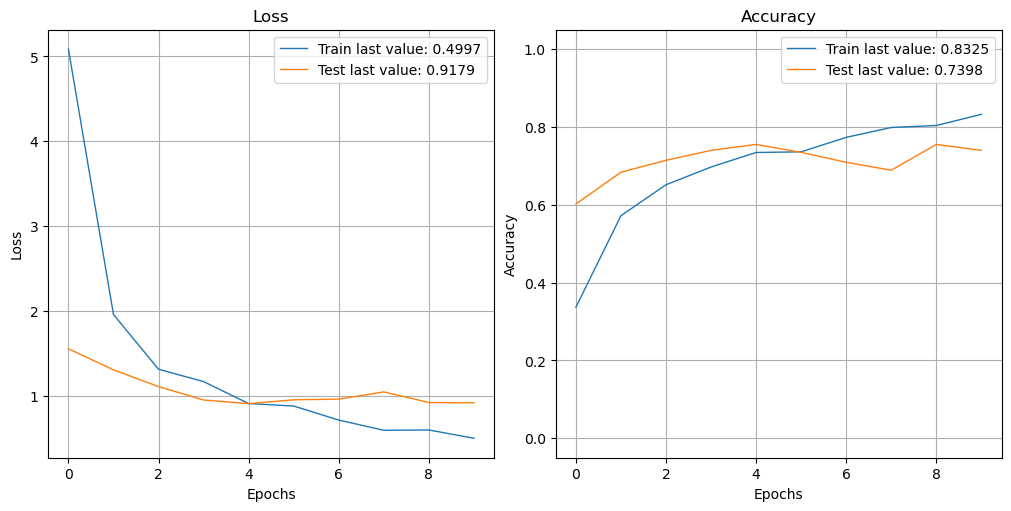

In [79]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

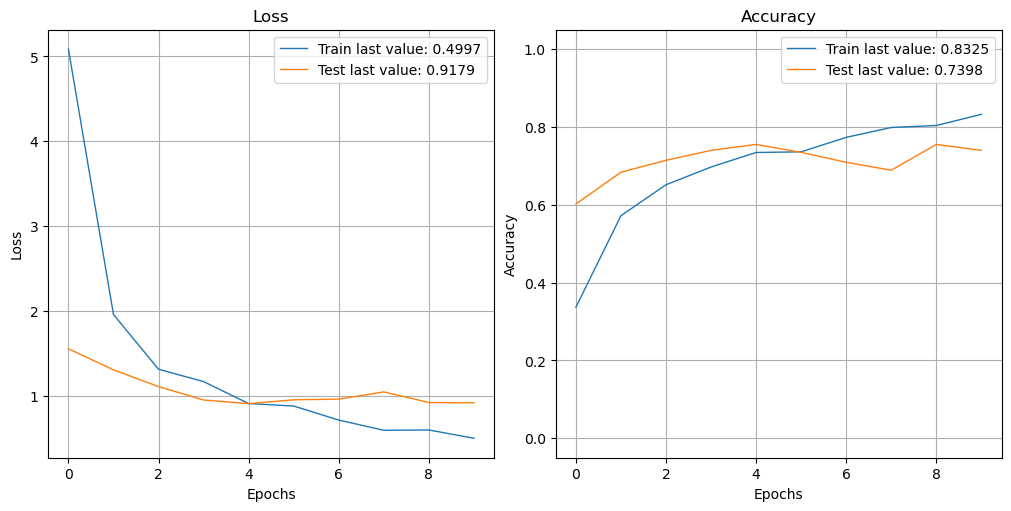

In [80]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

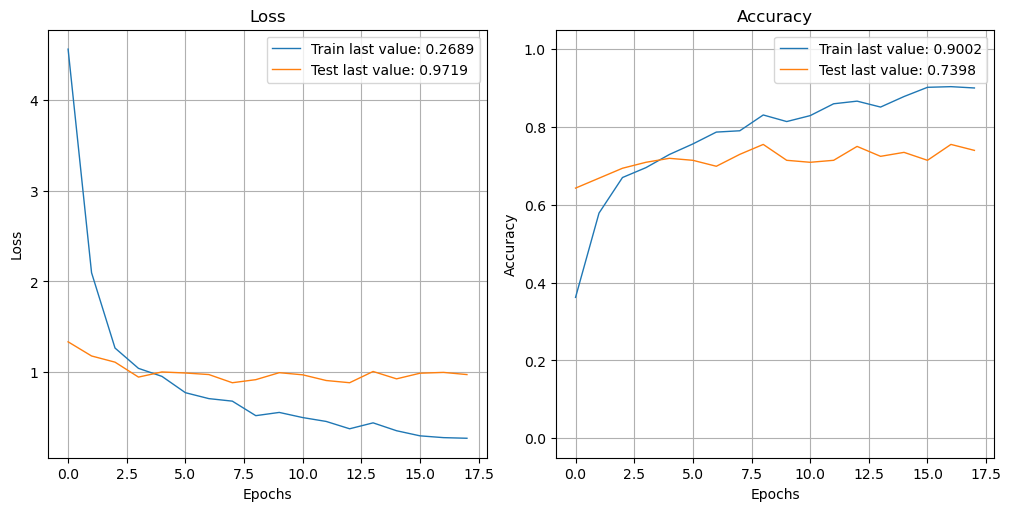

In [48]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

In [23]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model2.predict(X_val), axis=1)

print(y_val_num)
print()
print(y_val_pred)

5/5 [==============================] - 13s 2s/step
[6 2 0 6 4 0 6 5 4 6 3 3 4 6 5 3 4 5 2 4 5 5 3 1 2 3 4 2 5 3 1 0 5 6 6 4 0
 2 3 0 3 3 0 6 6 0 0 3 1 2 6 4 2 2 6 1 1 3 4 0 0 2 1 0 0 1 4 3 4 2 1 3 2 3
 3 1 1 1 4 4 6 1 2 0 4 2 4 0 4 5 4 1 0 6 2 2 5 5 1 1 1 4 5 0 5 1 6 0 0 2 6
 6 5 1 3 4 2 5 5 5 6 2 5 4 2 2 6 5 0 6 2 1 3 0 3 1 0 6 1 3 6 0 3 0 6 6 5 4
 5 2 4 0 6 3 5 1 3 0]

[6 2 0 6 4 0 6 5 4 6 3 3 4 6 5 3 4 5 2 4 5 5 1 1 1 3 4 2 5 3 1 0 5 6 6 4 0
 2 3 0 3 3 0 6 6 0 0 3 1 2 6 4 2 2 6 1 1 3 4 0 0 2 1 0 0 1 4 3 4 2 1 3 0 3
 0 1 1 1 4 0 6 1 3 4 4 2 4 0 4 5 4 1 2 6 2 2 3 5 1 1 1 4 5 0 5 1 6 4 0 2 6
 6 5 1 3 4 2 5 5 5 6 2 5 4 2 2 6 5 0 6 2 1 3 4 0 1 3 6 1 3 6 1 3 0 6 4 5 0
 5 3 4 0 6 3 5 1 3 5]


In [24]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[18  1  1  1  3  1  0]
 [ 0 22  0  0  0  0  0]
 [ 1  1 18  2  0  0  0]
 [ 2  1  0 19  0  0  0]
 [ 2  0  0  0 20  0  0]
 [ 0  0  0  1  0 20  0]
 [ 0  0  0  0  1  0 23]]


In [28]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[18  1  1  1  3  1  0]
 [ 0 22  0  0  0  0  0]
 [ 1  1 18  2  0  0  0]
 [ 2  1  0 19  0  0  0]
 [ 2  0  0  0 20  0  0]
 [ 0  0  0  1  0 20  0]
 [ 0  0  0  0  1  0 23]]

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        25
           1       0.88      1.00      0.94        22
           2       0.95      0.82      0.88        22
           3       0.83      0.86      0.84        22
           4       0.83      0.91      0.87        22
           5       0.95      0.95      0.95        21
           6       1.00      0.96      0.98        24

    accuracy                           0.89       158
   macro avg       0.89      0.89      0.89       158
weighted avg       0.89      0.89      0.89       158



<Axes: >

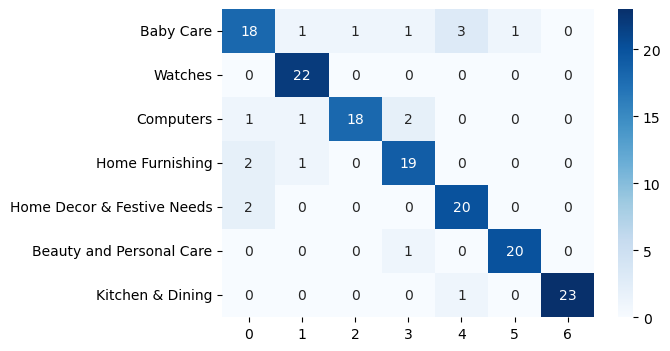

In [32]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels.index],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### Fin